In [9]:
# Core jax
import jax.numpy as np
import jax.random as jr
from jax.scipy.stats import poisson
from jax import vmap

# ∂Lux
import dLux as dl

# Optimisation
import zodiax as zdx
import optax

# Plotting and visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

In [10]:
import tensorflow_datasets as tfds

mnist_data, _ = tfds.load(
    name="mnist", batch_size=-1, with_info=True, as_supervised=True
)
mnist_data = tfds.as_numpy(mnist_data)
data_train, data_test = mnist_data["train"], mnist_data["test"]

def one_hot_encode(x, k, dtype=np.float32):
    "Create a one-hot encoding of x of size k."
    return np.array(x[:, None] == np.arange(k), dtype)

def prepare_data(dataset: tuple, num_categories=10):
    X, y = dataset
    y = one_hot_encode(y, num_categories)

    num_examples = X.shape[0]
    num_pixels = 28 * 28
    X = X.reshape(num_examples, num_pixels)
    X = X / 255.0

    return np.array(X), np.array(y), num_examples

def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jax.random.split(rng_key)
        idx = jax.random.choice(
            key=rng_key, a=np.arange(data_size), shape=(batch_size,)
        )
        minibatch = tuple(elem[idx] for elem in data)
        yield minibatch

X_train, y_train, N_train = prepare_data(data_train)
X_test, y_test, N_test = prepare_data(data_test)

In [11]:
def ent(array, eps=1e-10):
    """calcualtes the entropy of the array"""
    return -np.sum(array * np.log(array + eps))

def total_variation(array):
    """calcualtes the total variation of the array"""
    array = np.pad(array, 2)
    diff_y = np.abs(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.abs(array[:, 1:] - array[:, :-1]).sum()
    return diff_x + diff_y

def quadratic_variation(array):
    """calcualtes the quadratic variation of the array"""
    array = np.pad(array, 2)
    diff_y = np.square(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.square(array[:, 1:] - array[:, :-1]).sum()
    return diff_x + diff_y


In [12]:
# Distribution
distribution = X_train[2].reshape(28, 28)
distribution /= distribution.sum()

# Distributions
N = 5
distributions = X_train[:N].reshape(N, 28, 28)
distributions /= distributions.sum((-1, -2), keepdims=True)

# Source and spectrum
flux = 1e6
wavels = np.linspace(5e-7, 6e-7, 5)
spec = dl.ArraySpectrum(wavels)
source = dl.ArrayDistribution(flux=flux, distribution=distribution, spectrum=spec)

# Oversampling
npix = 100
oversample = 1

# Optics
phase_mask = np.load("/Users/louis/PhD/dLux/docs/notebooks/files/test_mask.npy")
mask = dl.utils.phase_to_opd(phase_mask, wavels.mean())
mask_layer = dl.AddOPD(mask)
nzernike = 7
coeffs = 2e-8*jr.normal(jr.PRNGKey(0), (nzernike,))
optics = dl.utils.toliman(256, npix*oversample, nzernike=nzernike,
    zernike_coefficients=coeffs, extra_layers=[mask_layer])

# Detector
BG = 10
detector = dl.Detector([
    dl.IntegerDownsample(oversample),
    dl.AddConstant(BG)
])

# Make model
tel = dl.Instrument(optics, detector=detector, sources=[source])
dist = 'ArrayDistribution.distribution'
zern = 'CircularAperture.coefficients'
params = [dist, zern]
model = tel.set(params, [np.ones((28, 28)), np.zeros(nzernike)])

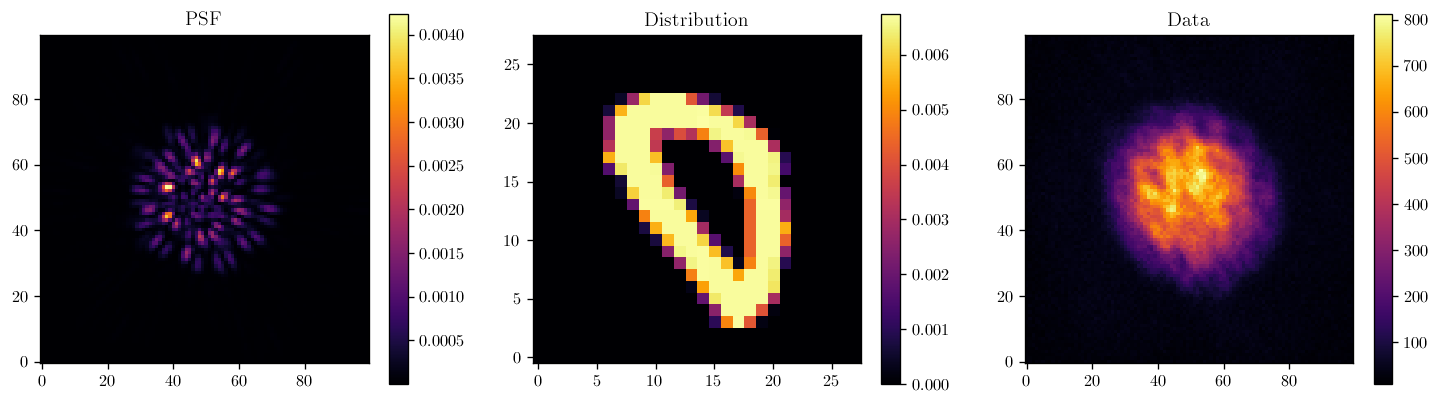

In [13]:
psf_conv = tel.model()
psf = tel.set(['scene.sources', 'detector'], 
              [dl.PointSource(flux=1, spectrum=spec), None]).model()
data = jr.poisson(jr.PRNGKey(1), psf_conv)
data += BG + 2*jr.normal(jr.PRNGKey(2), psf_conv.shape)

# Plot two images
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Distribution")
plt.imshow(distribution)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()

In [14]:
def loglike_loss(model, data):
    return -poisson.logpmf(data, model.model()).sum()

def entropy_loss(model):
    return -ent(model.normalise().get(dist))

def total_variation_loss(model):
    return total_variation(model.normalise().get(dist))

def quadratic_variation_loss(model):
    return quadratic_variation(model.normalise().get(dist))

In [15]:
@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn(model, data, alpha=1e3, beta=1e1, gamma=1e5):
    loss = loglike_loss(model, data)
    loss += alpha * entropy_loss(model)
    loss += beta * total_variation_loss(model)
    loss += gamma * quadratic_variation_loss(model)
    return loss

In [16]:
%%time
loss, grads = loss_fn(model, data)
print("Initial Loss: {}".format(loss))

Initial Loss: 69459.5546875
CPU times: user 542 ms, sys: 16.4 ms, total: 559 ms
Wall time: 428 ms


In [17]:
dist_optimiser = optax.adam(1e-1)
coeffs_optimiser = optax.adam(1e-8)
optimisers = [dist_optimiser, coeffs_optimiser]
optim, opt_state = zdx.get_optimiser(model, params, optimisers)

losses, models_out = [], [model]
with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, data)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.3f}".format(loss.mean())) # update the progress bar

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

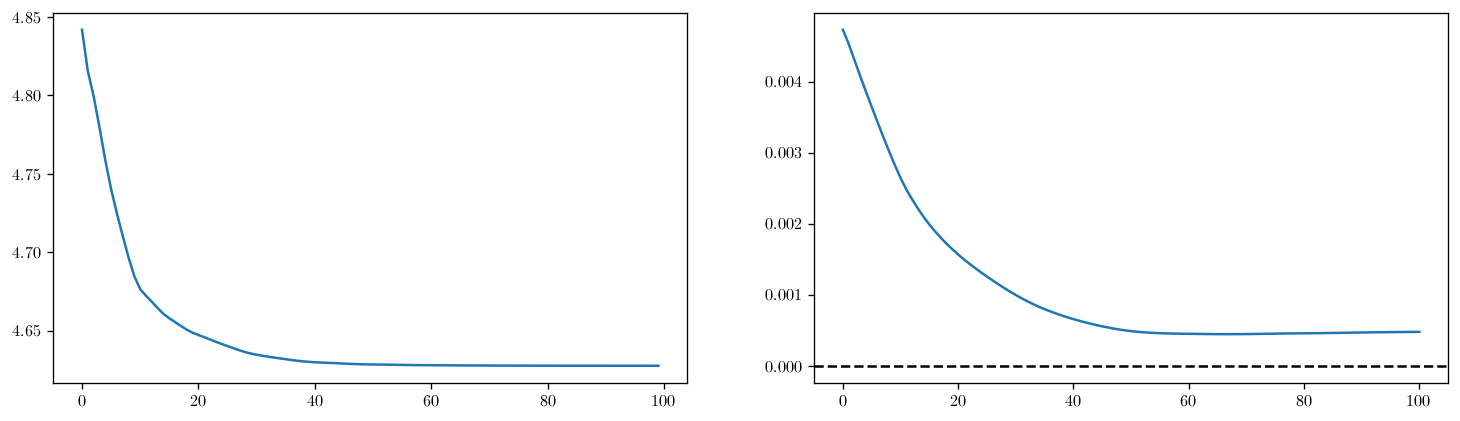

In [18]:
losses = np.array(losses)

dists_out = np.array([model.normalise().get(dist) for model in models_out])
dist_loss = np.square(distribution[None, :, :] - dists_out).sum((-1, -2))

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(np.log10(losses))

plt.subplot(1, 2, 2)
plt.plot(dist_loss)
plt.axhline(0, color='k', ls='--')
plt.show()

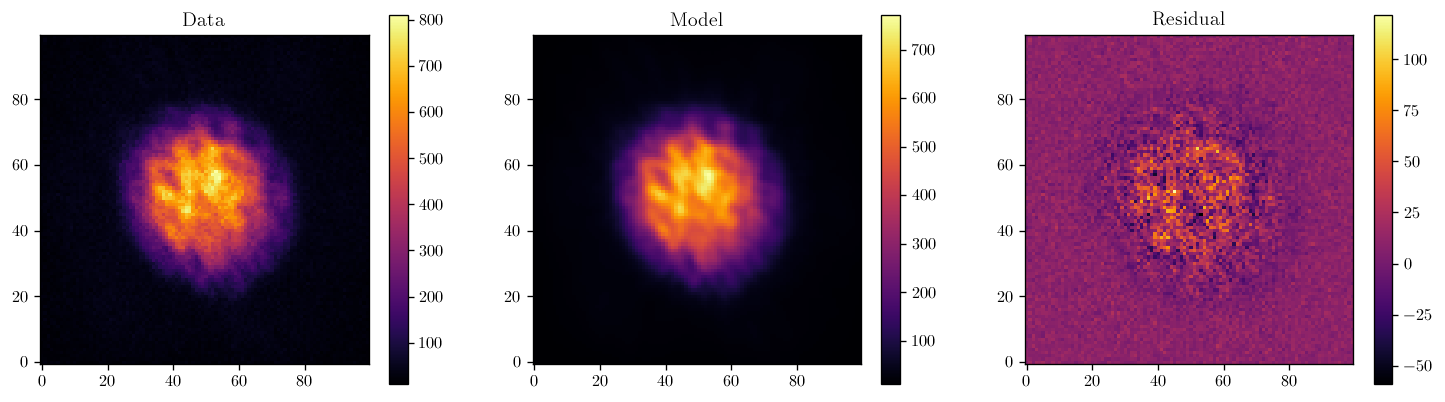

In [19]:
image = models_out[-1].model()

# Plot two images
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Data")
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(image)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(data - image)
plt.colorbar()
plt.show()

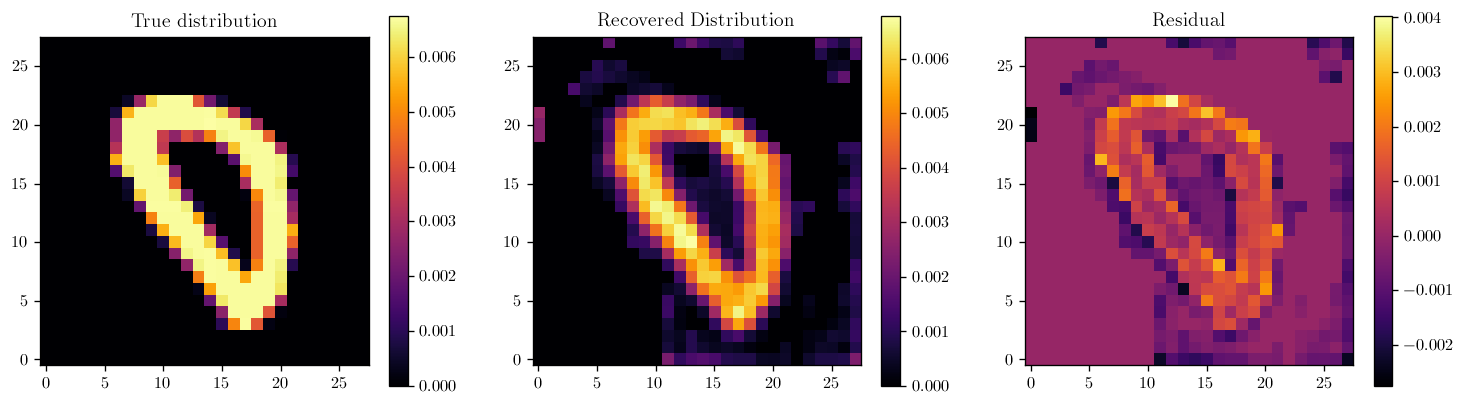

In [20]:
dist_out = models_out[-1].normalise().get(dist)
dist_out /= dist_out.sum()

# Plot two images
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("True distribution")
plt.imshow(distribution)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Recovered Distribution")
plt.imshow(dist_out)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(distribution - dist_out)
plt.colorbar()
plt.show()

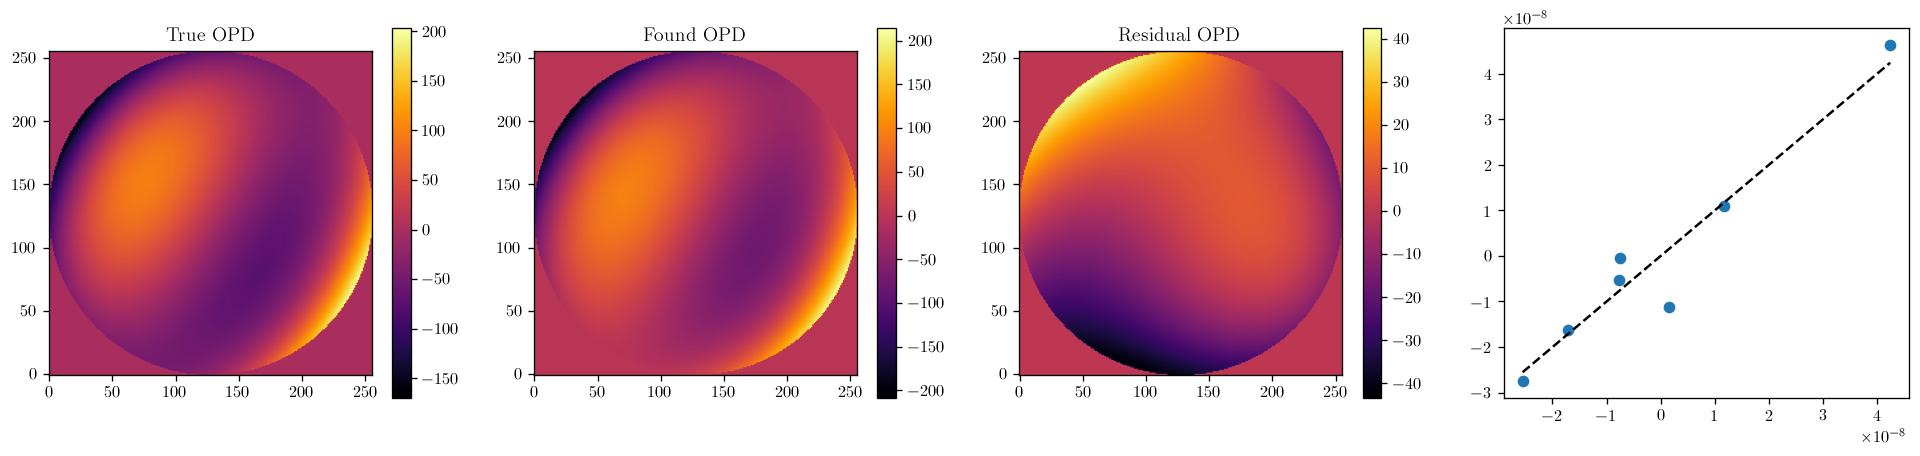

In [21]:
final_model = models_out[-1]
true_opd = tel.CircularAperture.get_opd()*1e9

found_opd = final_model.CircularAperture.get_opd()*1e9
residual_opd = true_opd - found_opd

true_coeffs = tel.get(zern)
found_coeffs = final_model.get(zern)

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.title("True OPD")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(1, 4, 2)
plt.title("Found OPD")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(1, 4, 3)
plt.title("Residual OPD")
plt.imshow(residual_opd)
plt.colorbar()

plt.subplot(1, 4, 4)
plt.scatter(true_coeffs, found_coeffs)
coeff_range = np.linspace(coeffs.min(), coeffs.max())
plt.plot(coeff_range, coeff_range, c='k', linestyle='--')
plt.show()

In [22]:
ll = loglike_loss(models_out[-1], data)
reg = entropy_loss(models_out[-1])
tv = total_variation_loss(models_out[-1])
qv = quadratic_variation_loss(models_out[-1])
print(np.log10(np.abs(ll)), np.abs(ll))
print(np.log10(np.abs(reg)), np.abs(reg))
print(np.log10(np.abs(tv)), np.abs(tv))
print(np.log10(np.abs(qv)), np.abs(qv))

4.679921 47854.316
0.7470414 5.585235
-0.05902304 0.87292504
-2.8135169 0.0015363249
